In [1]:
import os
import re 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm
import fsspec
import ee
#import spyndex
from haversine import  inverse_haversine, Unit


ee.Authenticate()
ee.Initialize()

from warnings import filterwarnings
path = '/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/2022-04-04.zarr/'

ds = xr.open_zarr(fsspec.get_mapper(path), consolidated=True)
#prediction = xr.open_dataset('/home/jomueller/MasterArbeit/ml_classification/2022-04-01.v3.nc')

#ds['ice-type'] = prediction.prediction_rf
ds['BT56'] = ds.BT_2D.isel(band=3) - ds.BT_2D.isel(band=4)
ds['BT36'] = ds.BT_2D.isel(band=2) - ds.BT_2D.isel(band=4)
ds['BT26'] = ds.BT_2D.isel(band=1) - ds.BT_2D.isel(band=4)


ds_sel = ds.sel(time='2022-04-04T13:40:00', method='nearest')

#prediction.close()
ds_sel_array = ds.sel(time='2022-04-04T13:39:00')


min_lat, max_lat = ds_sel_array.lat.min().values.item(), ds_sel_array.lat.max().values.item()
min_lon, max_lon = ds_sel_array.lon.min().values.item(), ds_sel_array.lon.max().values.item()



time = ds_sel.time
date = ds_sel.time.dt.strftime('%Y-%m-%d').values.item()



def get_s2(band, date=date, min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon):

    dayOfInterest = ee.Date(date)

    ROI = ee.Geometry.BBox(min_lon, min_lat, max_lon, max_lat)
    ROI = ee.Geometry.buffer(ROI, 15000)


    image_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
                .filterDate(dayOfInterest, dayOfInterest.advance(1, 'day'))
                .filterBounds(ROI)
                .select(band))
                #.filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 100))#.maskClouds()

    # image_list = image_collection.toList(image_collection.size())
    # N = len(image_list) 

    # s2_image_list = []

    # image = ee.Image(image_list.get(0))
    # cropped = image.clipToBoundsAndScale(geometry = ROI,scale= 5)
    # xarray_image = cropped.wx.to_xarray(scale = 5)

    ds = xr.open_dataset(image_collection, 
                         engine='ee',
                         geometry=ROI,
                         scale=0.0001
    )

    return ds



Successfully saved authorization token.


ERROR 1: PROJ: proj_create_from_database: Open of /home/jomueller/micromamba/envs/mamba_josh/share/proj failed


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/jomueller/micromamba/envs/mamba_josh/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


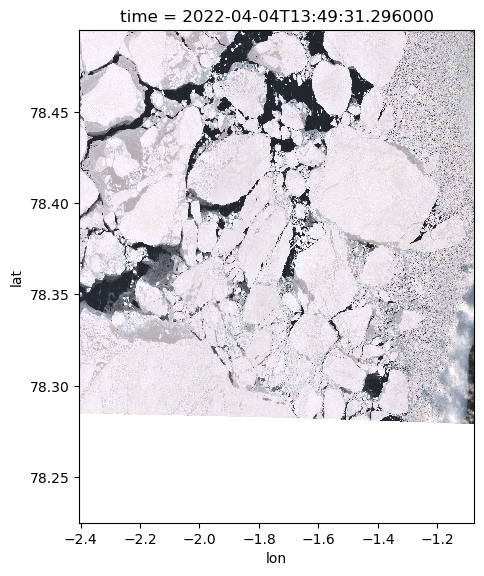

In [2]:
rgb = get_s2(['B4', 'B3', 'B2']).isel(time=1).to_array().transpose('lat', 'lon', 'variable').compute()
#.plot.imshow(x='lon')
### normalize the RGB values

(rgb / 1e4).plot.imshow(x='lon', y='lat', figsize=(5.1, 6.4))

In [3]:
# ds_clean = s2_image.sel(variable=['B4', 'B3', 'B2'])
ds_clean = rgb / 1e4
# ds_clean.plot.imshow()
import json  
plt.rcParams.update(json.load(open("../plot_settings.json", "r")))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


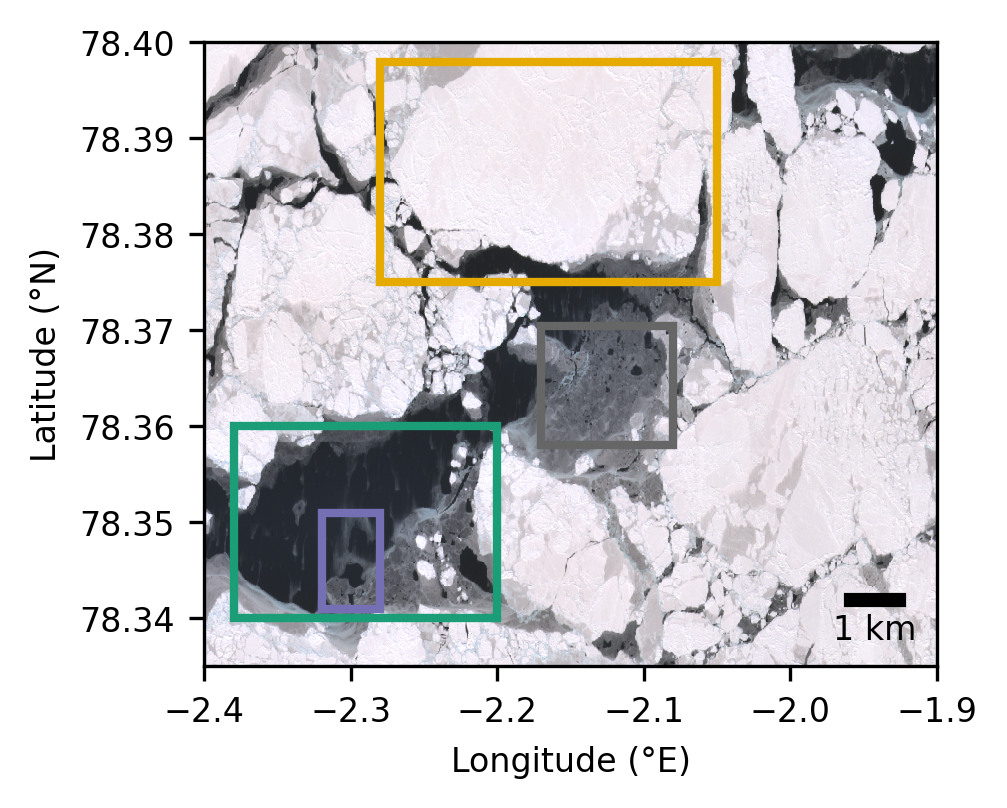

In [6]:

from matplotlib.patches import Rectangle, ConnectionPatch
axd = plt.figure(figsize=(3.15, 2.7)).subplot_mosaic(
    """
    AAA
    AAA
    AAA
    """
)


fs = 8
plt.rcParams['font.size'] = fs
plt.rcParams['axes.titlesize'] = fs
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['legend.fontsize'] = fs
plt.rcParams['figure.titlesize'] = fs


bbox1 = [-2.38, 78.34, -2.2, 78.36]
bbox2 = [-2.32, 78.341, -2.28, 78.351]
bbox3 = [-2.17, 78.358, -2.08, 78.3705]
bbox4 = [-2.28, 78.375, -2.05, 78.398]

ds_clean.plot.imshow(ax=axd['A'])

# ds_clean.sel(lat=slice(bbox1[1], bbox1[3]), lon=slice(bbox1[0], bbox1[2])).plot.imshow(ax=axd2['B'])
# ds_clean.sel(lat=slice(bbox2[1], bbox2[3]), lon=slice(bbox2[0], bbox2[2])).plot.imshow(ax=axd2['D'])
# ds_clean.sel(lat=slice(bbox3[1], bbox3[3]), lon=slice(bbox3[0], bbox3[2])).plot.imshow(ax=axd2['C'])
# ds_clean.sel(lat=slice(bbox4[1], bbox4[3]), lon=slice(bbox4[0], bbox4[2])).plot.imshow(ax=axd2['E'])




labeldict = {'A' : 'a',
             'B' : 'b',
             'C' : 'c',
             'D' : 'd',
             'E' : 'e'}


for key, value in axd.items():
    if key != 'A':
        value.set_xticks([])
        value.set_yticks([])
        value.set_xlabel('')
        value.set_ylabel('')
        #value.set_aspect('equal')
        value.set_facecolor('grey')
        value.set_title('')

        ## add (a) (b) (c) (d) (e) labels to subplots

        value.text(0.05, 0.8, f'({labeldict[key]})', transform=value.transAxes, fontdict={'fontsize': 10, 'fontweight': 'bold'})
    
    else:
        value.set_ylim(78.335, 78.37)
        value.set_title('')
        value.axes.grid(False)
        #value.text(0.05, 0.95, f'({labeldict[key]})', transform=value.transAxes, fontdict={'fontsize': 10, 'fontweight': 'bold'})

# Function to draw zoom lines
def draw_zoom_lines(ax_main, bbox, edgecolor='black', ):
    # Rectangle on the main plot
    rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], 
                     fill=False, edgecolor=edgecolor, lw=2)
    ax_main.add_patch(rect)







colors = np.array([[0.10588235, 0.61960784, 0.46666667, 1.],
                [0.45882353, 0.43921569, 0.70196078, 1.],
                [0.4       , 0.4       , 0.4       , 1.],
                [0.90196078, 0.67058824, 0.00784314, 1.],
])


from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

scalebar = AnchoredSizeBar(axd['A'].transData,
                            0.04, '1 km', 'lower right', 
                            pad=0.5,
                            color='black',
                            frameon=False,
                            size_vertical=0.001,
                            fontproperties={'size': 8})

axd['A'].add_artist(scalebar)
axd['A'].set_xlabel('Longitude (°E)')
axd['A'].set_ylabel('Latitude (°N)')

axd['A'].set_ylim(78.335, 78.4)
axd['A'].set_xlim(-2.4, -1.9)
configs = ['down', 'down', 'down', 'up']


bboxes = [
    bbox1,
    bbox2,
    bbox3,
    bbox4
]
c = 0
for key, bbox in zip('BCDE', bboxes):
    color = colors[c]
    config = configs[c]
    c += 1
    draw_zoom_lines(axd['A'], bbox, edgecolor=color)


plt.savefig('../../plots/publish/figure05.png', dpi=300, bbox_inches='tight')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


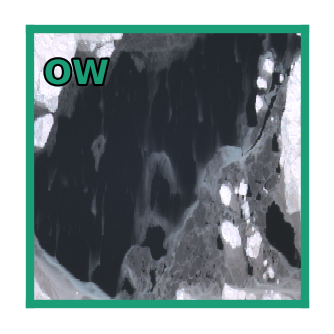

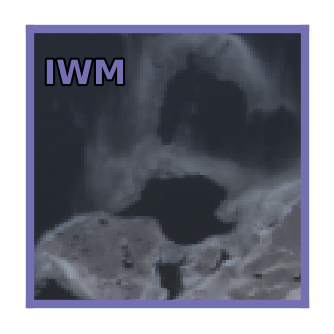

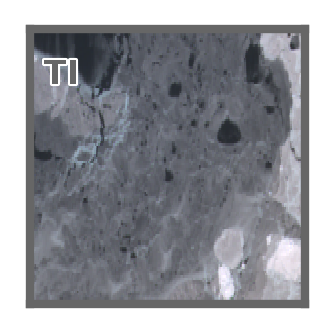

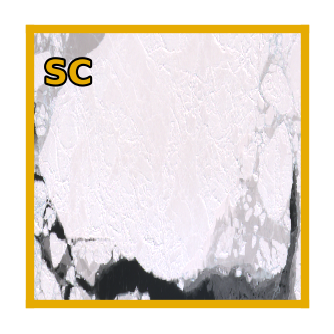

In [8]:
from matplotlib import patheffects as pe

bboxes = [
    bbox1,
    bbox2,
    bbox3,
    bbox4
]

colors = [
    [0.10588235, 0.61960784, 0.46666667, 1.],
    [0.45882353, 0.43921569, 0.70196078, 1.], 
    [0.4, 0.4, 0.4, 1.],
    [0.90196078, 0.67058824, 0.00784314, 1.]
]

texts = ['OW', 'IWM', 'TI', 'SC']

for i, (bbox, color) in enumerate(zip(bboxes, colors)):
    fig, ax = plt.subplots(1, 1, figsize=(1, 1), constrained_layout=True)
    ds_clean.sel(lat=slice(bbox[1], bbox[3]), lon=slice(bbox[0], bbox[2])).plot.imshow(ax=ax)
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(2)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    if i == 2:
        foreground = 'white'
    else:
        foreground = 'black'
    ax.text(0.05, 0.8, texts[i], transform=ax.transAxes, fontdict={'fontsize': 8, 'fontweight': 'bold', 'color': color}, path_effects=[pe.Stroke(linewidth=1, foreground=foreground), pe.Normal()])
    plt.savefig(f'../../plots/publish/table02/showcase_2022-04-04_{texts[i]}.png', dpi=300)